In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,5)})
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm

In [3]:
import requests

In [4]:
with open('token.txt', 'r') as f:
    API_TOKEN = f.readlines()[0][:-1]

In [6]:
import berserk

session = berserk.TokenSession(API_TOKEN)
client = berserk.Client(session=session)

In [9]:
# berserk.enums.PerfType.BLITZ

In [10]:
def color2bool(color):
    if color == 'white':
        return True
    else:
        return False

def bool2color(b):
    if b:
        return 'white'
    else:
        return 'black'

def flip_color(color):
    if color == 'white':
        return 'black'
    else:
        return 'white'

In [11]:
def my_color(playes_data):
    if playes_data['white']['user']['name'] == 'menisadi':
        return 'white'
    else:
        return 'black'

In [12]:
def opponent_name(playes_data):
    return playes_data[flip_color(my_color(playes_data))]['user']['name']

In [13]:
games = client.games.export_by_player(username='menisadi', perf_type='blitz', 
                                          rated=True, analysed=True, opening=True, 
                                          evals=True)

## One game

In [14]:
first_game = next(games)

In [15]:
playes = first_game['players']

meni_color = my_color(playes)

my_rating = first_game['players'][meni_color]['rating']
opponent_rating = first_game['players'][flip_color(meni_color)]['rating']
opponent = opponent_name(first_game['players'])

time = first_game['createdAt']

termination = first_game['status']

winner = first_game['winner']
did_i_win = winner == meni_color

openning = first_game['opening']['name']

moves = first_game['moves']
game_length = len(moves.split(' '))

my_accuracy = first_game['players'][meni_color]['analysis']['acpl']
opponent_accuracy = first_game['players'][flip_color(meni_color)]['analysis']['acpl']

In [16]:
new_row = pd.DataFrame([{
        'time': time,
        'opponent_name': opponent,
        'my_rating': my_rating,
        'my_color': meni_color,
        'result': winner,
        'did_I_win': did_i_win, 
        'termination_type': termination,
        'length_of_game': game_length,
        'my_average_centripawn_loss': my_accuracy,
        'opponent_average_centripawn_loss': opponent_accuracy
}])

## And now we loop

In [17]:
df = pd.DataFrame(
    columns=['time', 'opponent_name', 'my_rating', 'my_color', 
             'result', 'termination_type', 'length_of_game', 
             'my_acpl', 'opponent_acpl', 
             'my_blunders', 'opponent_blunders',
             'opening'])

In [18]:
for game in games:

    playes = game['players']

    meni_color = my_color(playes)
    my_rating = game['players'][meni_color]['rating']
    opponent_rating = game['players'][flip_color(meni_color)]['rating']
    opponent = opponent_name(game['players'])
    
    time = game['createdAt']
    termination = game['status']
    try:
        winner = game['winner']
    except:
        windder = 'draw'
    did_i_win = winner == meni_color
    opening = game['opening']['name']
    moves = game['moves']
    game_length = len(moves.split(' '))
    my_accuracy = game['players'][meni_color]['analysis']['acpl']
    opponent_accuracy = game['players'][flip_color(meni_color)]['analysis']['acpl']
    my_blunders = game['players'][meni_color]['analysis']['blunder']
    opponent_blunders = game['players'][flip_color(meni_color)]['analysis']['blunder']
    new_row = pd.DataFrame([{
            'time': time,
            'opponent_name': opponent,
            'my_rating': my_rating,
            'my_color': meni_color,
            'opening': opening,
            'result': winner,
            'did_I_win': did_i_win, 
            'termination_type': termination,
            'length_of_game': game_length,
            'my_acpl': my_accuracy,
            'opponent_acpl': opponent_accuracy,
            'my_blunders': my_blunders, 
            'opponent_blunders': opponent_blunders,
    }])

    df = pd.concat([df, new_row])

print('Done')

/var/folders/nw/8w_76z_n6fz418hmsps2_rq40000gn/T/ipykernel_29091/2084837094.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row])


Done


In [19]:
df = df.sort_values(by='time')
df = df.reset_index().drop('index', axis=1)

In [20]:
df['opening_core'] = df['opening'].apply(lambda o: o.split(':')[0])

In [21]:
openings_df = df.groupby(['opening_core', 'my_color'])['did_I_win'].agg(['mean', 'count']).sort_values(by='count', ascending=False)

In [23]:
openings_df[openings_df['count'] > 5].rename(columns={'mean': 'win_rate', 'count': 'games'})

,,win_rate,games
opening_core,my_color,,
Caro-Kann Defense,black,0.524096,166
Queen's Gambit Declined,white,0.612613,111
Slav Defense,white,0.633333,30
Queen's Gambit Accepted,white,0.482759,29
King's Indian Defense,white,0.277778,18
Queen's Pawn Game,black,0.5,16
Englund Gambit Complex,white,0.466667,15
Indian Defense,black,0.733333,15
King's Indian Defense,black,0.357143,14


In [24]:
df['total_acpl'] = df['my_acpl'] + df['opponent_acpl']

In [25]:
df['my_cpl'] = df['my_acpl'] * df['length_of_game']
df['opponent_cpl'] = df['opponent_acpl'] * df['length_of_game']
df['total_cpl'] = df['total_acpl'] * df['length_of_game']

In [26]:
df['total_blunders'] = df['my_blunders'] + df['opponent_blunders']

In [27]:
df[
['opponent_name', 'my_rating', 'total_blunders',
 'termination_type', 'did_I_win',  'length_of_game',
 'total_acpl', 'my_acpl', 'opponent_acpl']
].sort_values(by=[
    'total_acpl', 'total_blunders', 'my_acpl', 'opponent_acpl', 'length_of_game'
]).head(20)

,opponent_name,my_rating,total_blunders,termination_type,did_I_win,length_of_game,total_acpl,my_acpl,opponent_acpl
214,bsjsizs,1463,0,timeout,True,5,19,5,14
452,Castling2022,1520,3,draw,True,229,24,12,12
75,felipevgalisteo,1409,2,mate,True,156,26,8,18
370,HaFu5,1461,0,resign,True,12,28,12,16
251,tikam1976,1414,0,outoftime,True,54,31,14,17
417,Daemon99,1478,1,resign,True,94,33,6,27
401,Invisiveuls,1477,1,resign,True,43,34,28,6
457,Ajnstajn123,1484,2,outoftime,False,78,34,17,17
248,rafe3,1407,2,mate,False,157,37,23,14
21,Andreas1010,885,1,resign,True,51,45,4,41


In [29]:
selected_columns = ['opponent_name', 'my_rating', 'total_blunders',
                    'termination_type', 'did_I_win',  'length_of_game',
                    'total_acpl', 'my_acpl', 'opponent_acpl']
df[df['total_blunders'] ==0].sort_values(by='length_of_game', ascending=False).head()[selected_columns]

,opponent_name,my_rating,total_blunders,termination_type,did_I_win,length_of_game,total_acpl,my_acpl,opponent_acpl
35,Ushamalhotra,1015,0,outoftime,False,89,82,32,50
140,arvinsaeed,1346,0,mate,True,79,53,15,38
22,iPenguin42,901,0,mate,True,67,67,19,48
11,Fajresss,856,0,outoftime,True,60,143,63,80
500,Lakshya806,1457,0,outoftime,False,59,71,25,46


In [30]:
df.loc[df['length_of_game'] > 25, ['opponent_name', 'my_rating', 'total_blunders',
                                    'termination_type', 'did_I_win',  'length_of_game',
                                    'total_cpl', 'my_acpl', 'opponent_acpl'
                                   ]].sort_values(by=[
    'total_cpl', 'length_of_game'], ascending=[True, False]).head(10)

,opponent_name,my_rating,total_blunders,termination_type,did_I_win,length_of_game,total_cpl,my_acpl,opponent_acpl
377,chyngyz_isakov88,1468,1,resign,True,26,1300,5,45
62,szmik,1239,1,outoftime,True,28,1316,7,40
441,verboseamoeba,1498,1,resign,True,26,1430,5,50
365,AlprnKrmn,1455,0,resign,True,27,1431,14,39
211,Akumed,1426,1,resign,True,30,1440,2,46
401,Invisiveuls,1477,1,resign,True,43,1462,28,6
251,tikam1976,1414,0,outoftime,True,54,1674,14,17
50,Angelina15,1214,1,resign,True,35,1680,4,44
150,dps78,1351,0,timeout,True,30,1800,30,30
379,neurosecond,1471,1,resign,True,30,1800,14,46


In [31]:
df = df.infer_objects()

In [37]:
# df.to_parquet('analyzed.parquet')

In [36]:
df.groupby('opening_core')['my_acpl'].agg(['min', 'max', 'count', 'mean', 'median']).sort_values(by='count', ascending=False).head()

,min,max,count,mean,median
opening_core,,,,,
Caro-Kann Defense,2,258,167,59.149701,53.0
Queen's Gambit Declined,4,199,112,66.044643,60.0
Slav Defense,4,173,42,55.785714,50.0
King's Indian Defense,24,236,32,74.812500,63.0
Queen's Gambit Accepted,4,206,29,73.620690,55.0


In [38]:
df.groupby('opening_core')['length_of_game'].agg(['min', 'max', 'count', 'mean', 'median']).sort_values(by='count', ascending=False).head()

,min,max,count,mean,median
opening_core,,,,,
Caro-Kann Defense,11,157,167,67.143713,61.0
Queen's Gambit Declined,15,159,112,63.696429,57.0
Slav Defense,5,128,42,58.928571,63.0
King's Indian Defense,35,126,32,68.687500,61.5
Queen's Gambit Accepted,13,124,29,54.793103,48.0


In [76]:
pivot_opennings = df.groupby(
    'opening_core'
)['termination_type'].agg(
    ['value_counts']
).pivot_table(index='opening_core', columns='termination_type', aggfunc='sum', fill_value=0)
pivot_opennings['sum'] = pivot_opennings.sum(axis=1)
pivot_opennings.sort_values(by='sum', ascending=False).head(8)

value_counts                                          \
termination_type                draw mate outoftime resign stalemate timeout   
opening_core                                                                   
Caro-Kann Defense                  8   41        51     65         0       2   
Queen's Gambit Declined            2   22        37     48         3       0   
Slav Defense                       1    8        11     20         0       2   
King's Indian Defense              0    8        16      7         0       1   
Queen's Gambit Accepted            0    9         7     12         0       1   
Queen's Pawn Game                  0    9         5     13         0       0   
Indian Defense                     1    7         6      7         0       0   
Englund Gambit Complex             1    3         2      9         0       0   

                         sum  
termination_type              
opening_core                  
Caro-Kann Defense        167  
Queen's Gambit Declined  112  
Slav Defense              42  
King's Indian Defense     32  
Queen's Gambit Accepted   29  
Queen's Pawn Game         27  
Indian Defense            21  
Englund Gambit Complex    15

In [77]:
pivot_opennings.columns = ['draw', 'mate', 'outoftime',	'resign', 'stalemate', 'timeout', 'sum']

In [78]:
def normalize_row(row):
    row_sum = row.sum() - row['sum']  # Exclude the sum column
    if row_sum == 0:
        return row  # If sum is 0, return original row
    else:
        normalized_row = row.drop('sum').div(row_sum).round(3)
        normalized_row['sum'] = row['sum']
        return normalized_row

In [84]:
pivot_opennings_normalized = pivot_opennings.apply(normalize_row, axis=1).sort_values(by='sum', ascending=False)

In [88]:
pivot_opennings_normalized.head(8)

,draw,mate,outoftime,resign,stalemate,timeout,sum
opening_core,,,,,,,
Caro-Kann Defense,0.048,0.246,0.305,0.389,0.000,0.012,167.0
Queen's Gambit Declined,0.018,0.196,0.330,0.429,0.027,0.000,112.0
Slav Defense,0.024,0.190,0.262,0.476,0.000,0.048,42.0
King's Indian Defense,0.000,0.250,0.500,0.219,0.000,0.031,32.0
Queen's Gambit Accepted,0.000,0.310,0.241,0.414,0.000,0.034,29.0
Queen's Pawn Game,0.000,0.333,0.185,0.481,0.000,0.000,27.0
Indian Defense,0.048,0.333,0.286,0.333,0.000,0.000,21.0
Englund Gambit Complex,0.067,0.200,0.133,0.600,0.000,0.000,15.0


<Axes: ylabel='opening_core'>

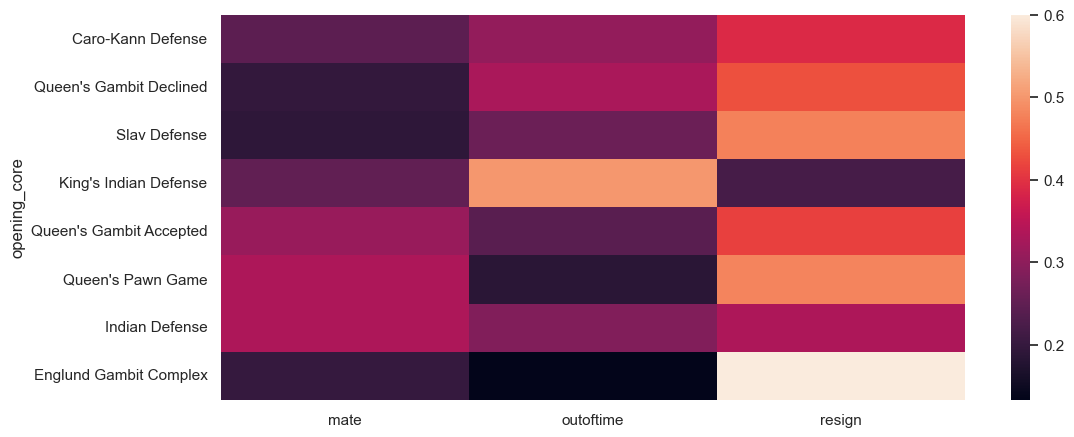

In [87]:
sns.heatmap(pivot_opennings_normalized.head(8).drop(['draw', 'stalemate', 'timeout', 'sum'], axis=1))

<Axes: xlabel='my_acpl', ylabel='opponent_acpl'>

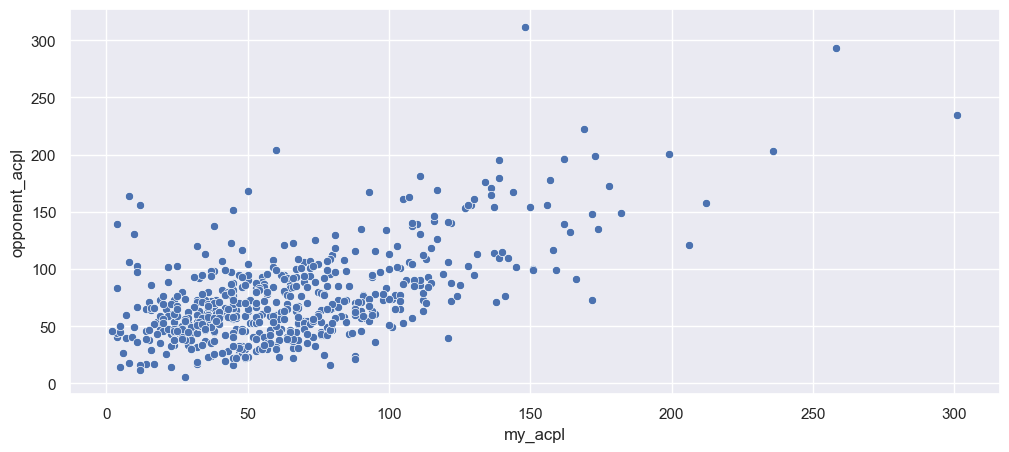

In [89]:
sns.scatterplot(data=df, x='my_acpl', y='opponent_acpl')

<Axes: xlabel='length_of_game', ylabel='total_acpl'>

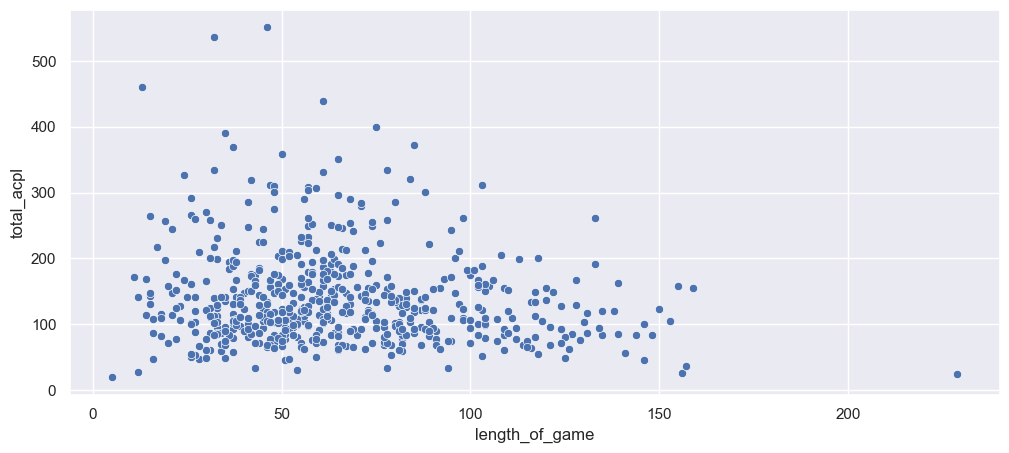

In [90]:
sns.scatterplot(data=df, x='length_of_game', y='total_acpl')

<Axes: xlabel='my_rating', ylabel='total_acpl'>

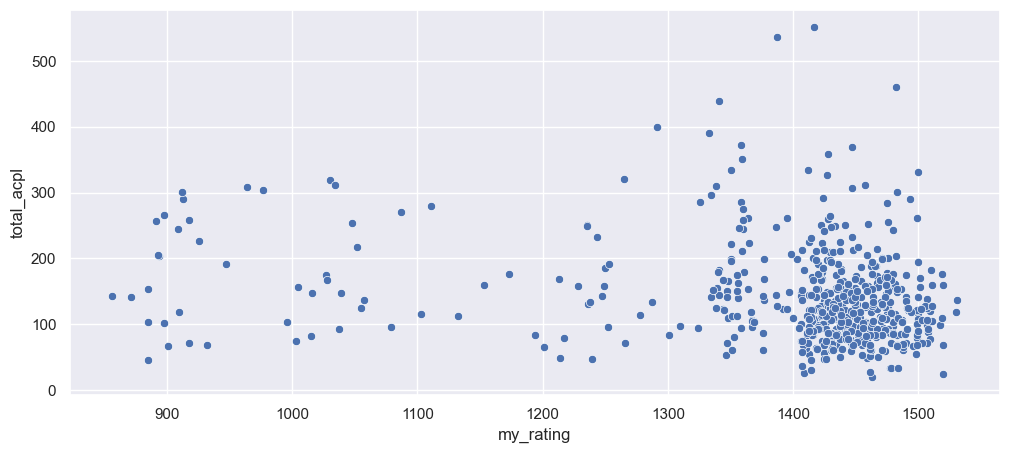

In [91]:
sns.scatterplot(data=df, x='my_rating', y='total_acpl')

Text(0.5, 1.0, 'My ACPL')

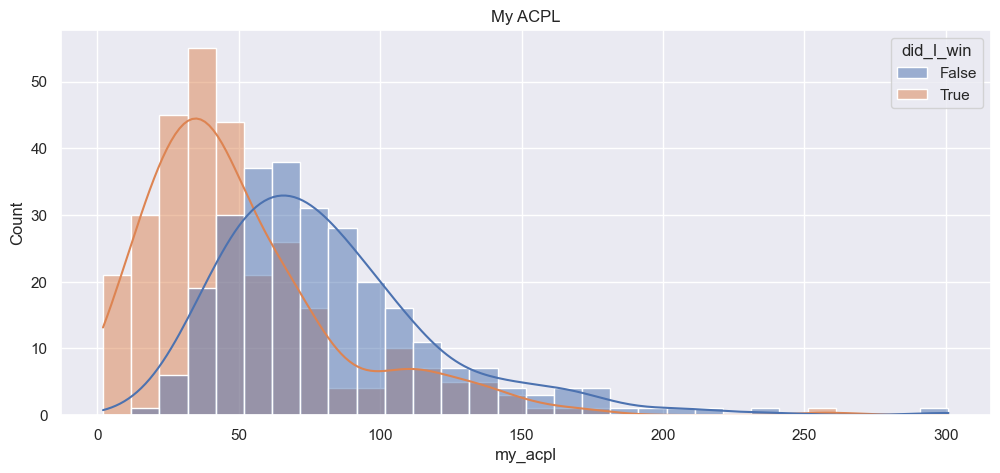

In [92]:
sns.histplot(data=df, x='my_acpl', hue='did_I_win', bins=30, kde=True)
plt.title('My ACPL')

Text(0.5, 1.0, 'Opponent ACPL')

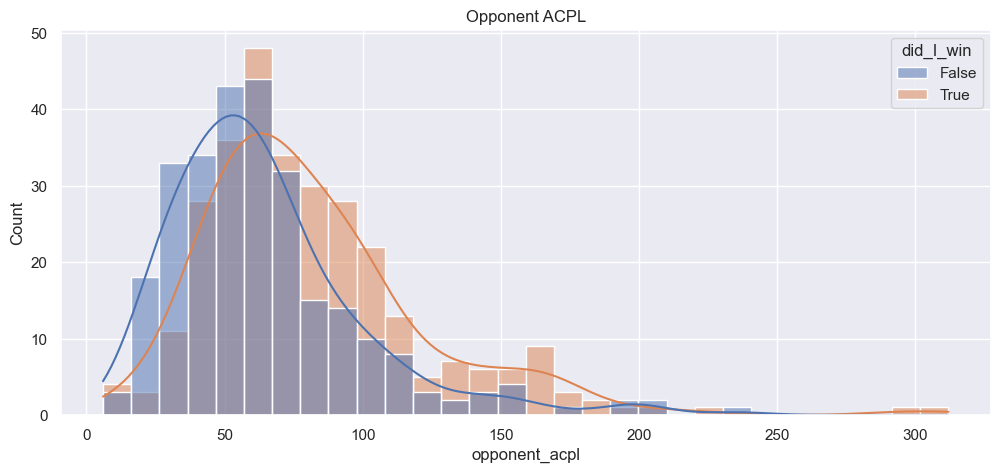

In [93]:
sns.histplot(data=df, x='opponent_acpl', hue='did_I_win', bins=30, kde=True)
plt.title('Opponent ACPL')

Text(0.5, 1.0, 'Total ACPL')

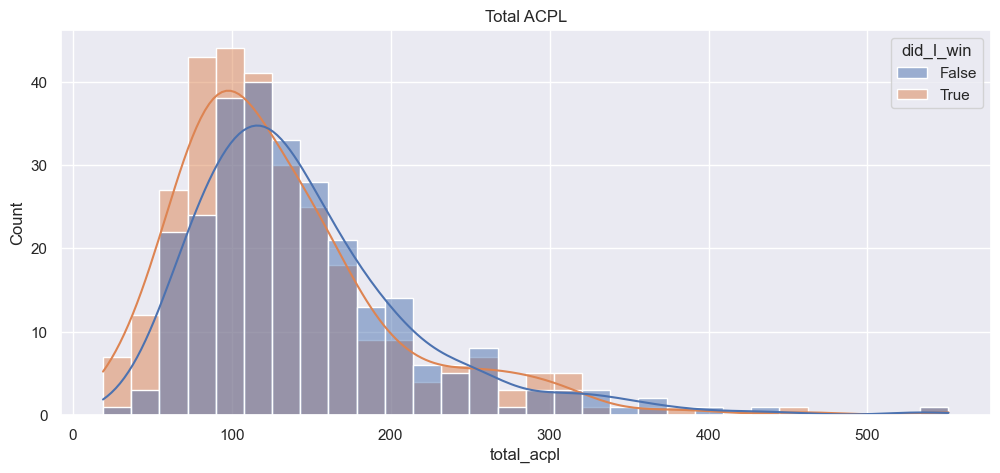

In [94]:
sns.histplot(data=df, x='total_acpl', hue='did_I_win', bins=30, kde=True)
plt.title('Total ACPL')

<Axes: xlabel='opening_core', ylabel='my_acpl'>

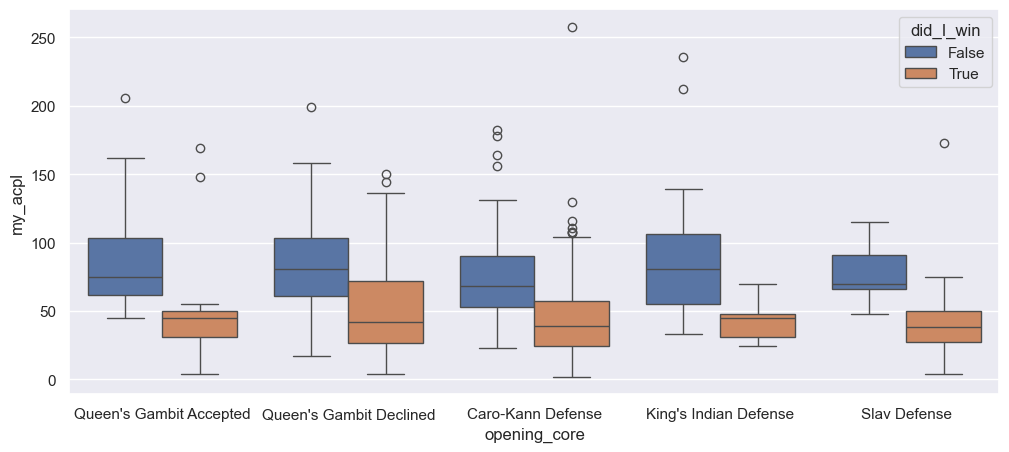

In [95]:
sns.boxplot(data=df[df['opening_core'].isin(df['opening_core'].value_counts().head().index)], 
            x='opening_core', y='my_acpl', hue='did_I_win')

<Axes: xlabel='opening_core', ylabel='total_acpl'>

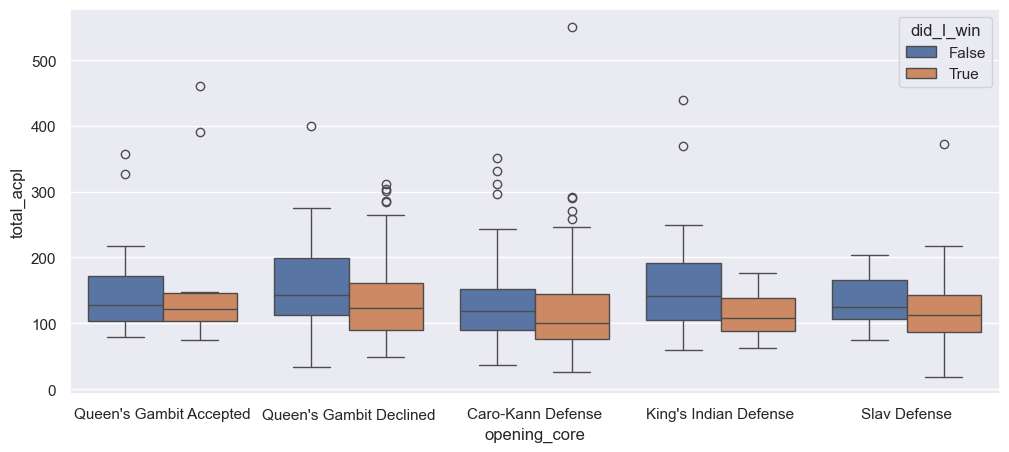

In [96]:
sns.boxplot(data=df[df['opening_core'].isin(df['opening_core'].value_counts().head().index)], 
            x='opening_core', y='total_acpl', hue='did_I_win')

<Axes: xlabel='opening_core', ylabel='my_acpl'>

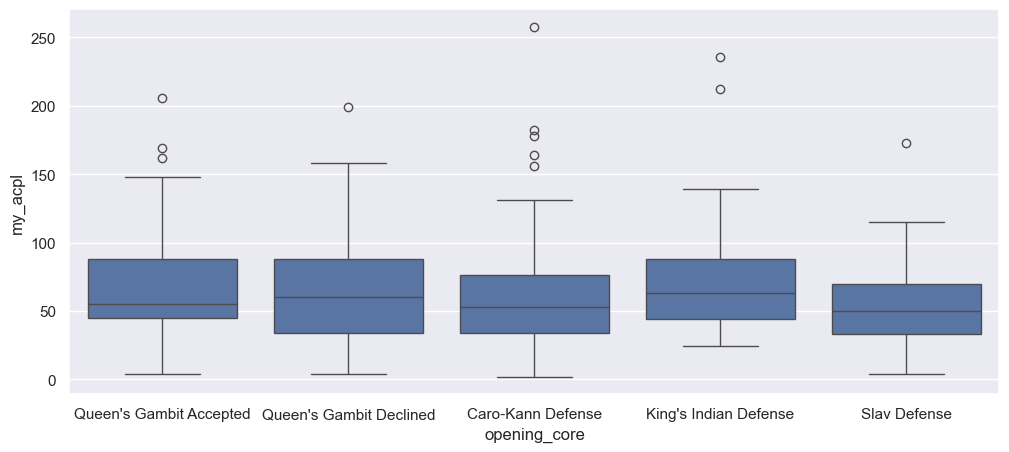

In [97]:
sns.boxplot(data=df[df['opening_core'].isin(df['opening_core'].value_counts().head().index)], 
            x='opening_core', y='my_acpl')

<Axes: xlabel='total_blunders', ylabel='count'>

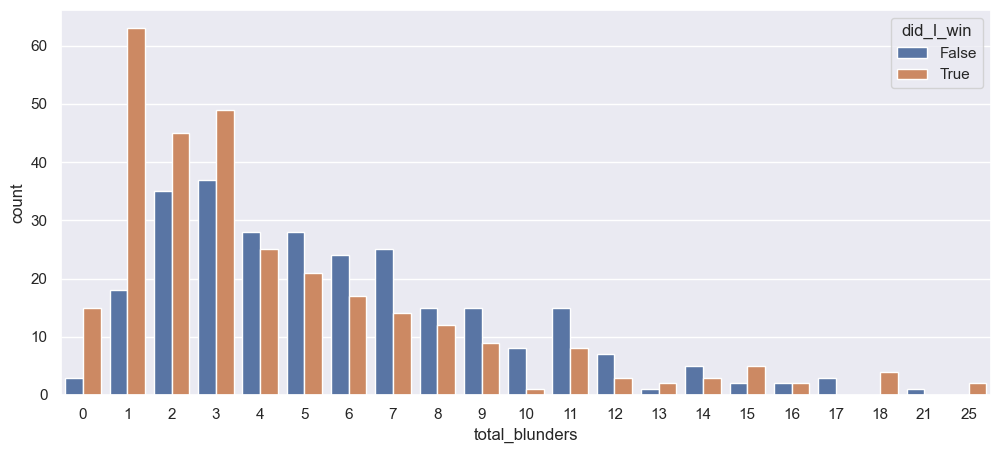

In [98]:
sns.countplot(data=df, x='total_blunders', hue='did_I_win')

<Axes: xlabel='did_I_win', ylabel='total_blunders'>

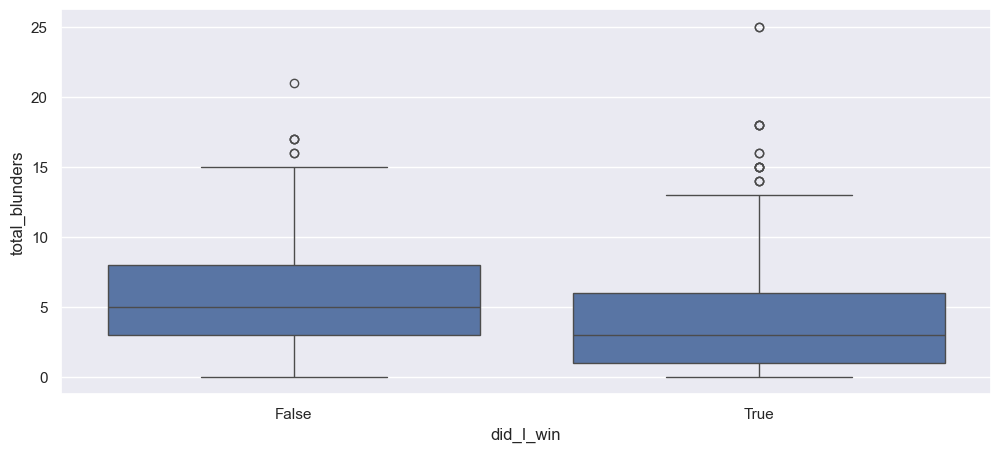

In [99]:
sns.boxplot(data=df, x='did_I_win', y='total_blunders')

In [100]:
df.loc[df['total_blunders']==1, 'did_I_win'].value_counts()

did_I_win
True     63
False    18
Name: count, dtype: int64

In [101]:
df.loc[df['total_blunders']==1, ['did_I_win', 'termination_type']].value_counts()

did_I_win  termination_type
True       resign              46
           mate                12
False      outoftime            8
           resign               7
True       outoftime            4
False      mate                 3
True       timeout              1
Name: count, dtype: int64